In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from scipy.fftpack import rfft,rfftfreq,irfft, fft
import datetime
from scipy.optimize import curve_fit,leastsq
from statsmodels.tsa.seasonal import seasonal_decompose


: 

In [ ]:
sp_data = pd.read_csv('sp500_data.csv')
print(sp_data.shape)
sp_data.drop(['Vol.'],axis=1,inplace=True)
sp_data.head()

(2809, 7)


,Date,Price,Open,High,Low,Change %
0,10/29/2023,"4,358.34","4,147.71","4,373.66","4,133.05",5.85%
1,10/22/2023,"4,117.37","4,206.30","4,259.49","4,103.49",-2.53%
2,10/15/2023,"4,224.16","4,351.28","4,393.73","4,222.38",-2.39%
3,10/08/2023,"4,327.78","4,288.38","4,386.00","4,283.82",0.45%
4,10/01/2023,"4,308.50","4,280.50","4,324.63","4,216.31",0.48%


In [3]:
#All data are type 'object' so first we need to convert the numerical ones to 'float' and the dates to 'datetime'.
sp_data.dtypes
cols = ['Price','Open','High','Low','Change %']
#We first need to remove the commas to the numbers.
for col in cols:
    for i in range(0,sp_data.shape[0]):
        sp_data.loc[i,col] = sp_data.loc[i,col].replace(',','')
        sp_data.loc[i,col] = sp_data.loc[i,col].strip(' %')

    sp_data[col] = sp_data[col].astype('float',copy=False)


In [4]:
sp_data.tail() 

,Date,Price,Open,High,Low,Change %
2804,02/01/1970,86.33,85.02,87.66,84.64,1.54
2805,01/25/1970,85.02,89.23,89.23,84.42,-4.87
2806,01/18/1970,89.37,90.72,90.80,88.64,-1.70
2807,01/11/1970,90.92,92.40,92.67,90.36,-1.60
2808,01/04/1970,92.40,93.00,94.25,91.82,0.54


In [4]:
#Dates to datetime:
for i in range(0,sp_data.shape[0]):
    sp_data.loc[i,'Date'] = datetime.datetime.strptime(sp_data.loc[i,'Date'],'%m/%d/%Y').date()#WTF hermano

In [5]:
def MA(data,period): 
    n = len(data) - period + 1
    result = np.linspace(0,0,n)
    for i in range(0,n):
        sum = 0
        for k in range(i,i+period):
            sum += data[k]
        result[i] = sum/period
    return result
def my_fft_week(data): #Derived from [b] in PDF references
    X = fft(data.values)
    N = len(X)
    n = np.arange(0,N)
    sr = 1/(24*60*60*7)
    Tot = N/sr
    freq = n/Tot
    #Frequency with half the time.
    n_oneside = N//2
    f_oneside = freq[:n_oneside]
    t_week = (1/f_oneside)/(60*60*24*7)
    return n_oneside,t_week,X,f_oneside
Tot = 2809*(3600*24*7) #Hard coded number! (It is the total number of seconds).
sr = 1/(24*60*60*7)

In [8]:
sp_MA_10 = MA(sp_data['Price'],10)
sp_MA_100 = MA(sp_data['Price'],100)
sp_MA_200 = MA(sp_data['Price'],200)

Text(0.5, 1.0, 'Escala logarítmica en Precios')

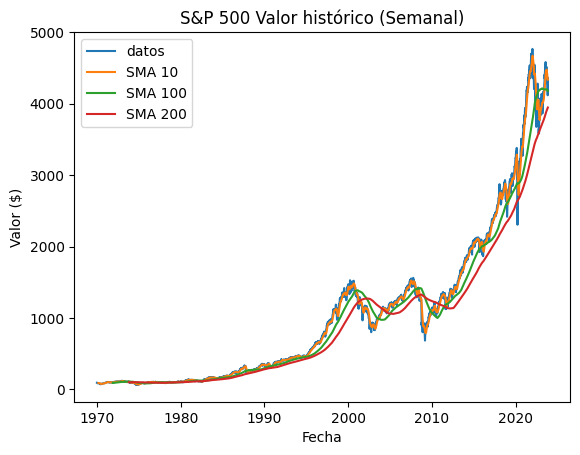

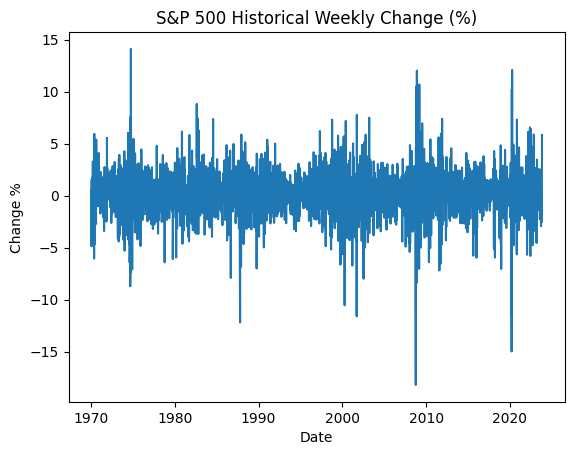

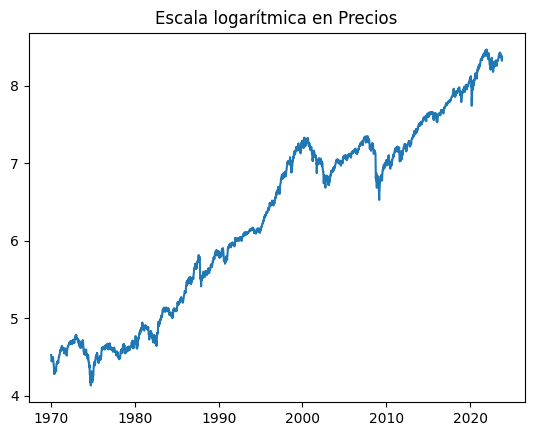

In [22]:
plt.figure(1)
plt.plot(sp_data['Date'],sp_data['Price'],label='datos')
plt.plot(sp_data['Date'][:-9],sp_MA_10,label='SMA 10')
plt.plot(sp_data['Date'][:-99],sp_MA_100,label='SMA 100')
plt.plot(sp_data['Date'][:-199],sp_MA_200,label='SMA 200')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.title('S&P 500 Historical value (Weeks)')
plt.figure(2)
plt.plot(sp_data['Date'],sp_data['Change %'])
plt.xlabel('Date')
plt.ylabel('Change %')
plt.title('S&P 500 Historical Weekly Change (%)')


plt.figure(3)
plt.plot(sp_data['Date'],np.log(sp_data['Price']))
plt.title('Logarithm(Price)')
plt.xlabel('Date')
plt.ylabel('Log(Price ($))')

[2.13245637e-04 4.20889900e+00]


Text(0.5, 1.0, 'Método de resta de la tendencia lineal')

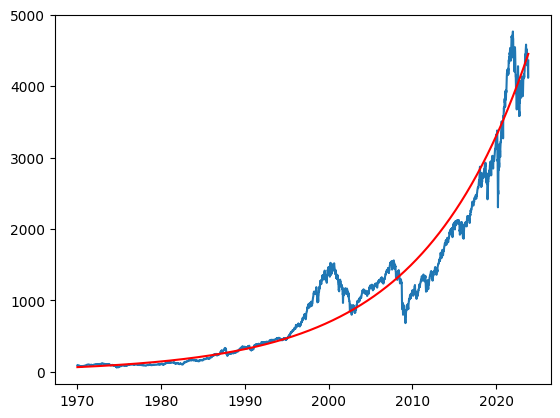

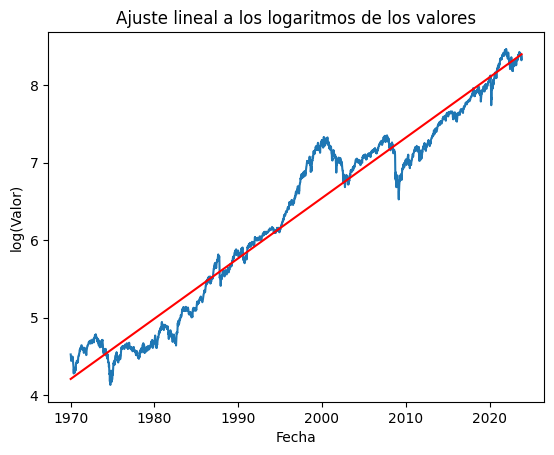

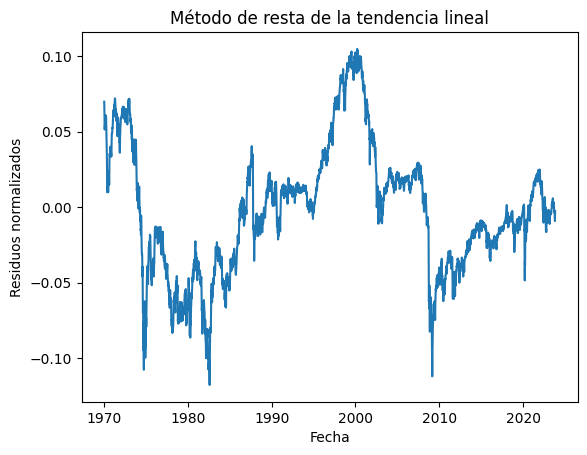

In [6]:
#Linear fit to the logarithm:
t = mdates.date2num(sp_data['Date'])
def ajuste(t,a,b):
    return a*t + b
def ajuste_real(t,a,b):
    return np.exp(a*t+b)
popt,pcov = curve_fit(ajuste,xdata=t,ydata=np.log(sp_data['Price']))
print(popt)
plt.figure(3)
plt.plot(sp_data['Date'],(sp_data['Price']))
plt.plot(sp_data['Date'],ajuste_real(t,*popt),'r-')
plt.figure(4)
plt.plot(sp_data['Date'],np.log(sp_data['Price']))
plt.plot(sp_data['Date'],ajuste(t,*popt),'r-')
plt.xlabel('Date')
plt.ylabel('log(Value)')
plt.title('Linear fit for log(Precio)')
#Residuos:
residuals = ((np.log(sp_data['Price']))-ajuste(t,*popt))/((np.log(sp_data['Price'])))
plt.figure(5)
plt.plot(sp_data['Date'],residuals)
plt.xlabel('Date')
plt.ylabel('Normalized residuals')
plt.title('Residuals after subtracting the subyacent tendency')

/tmp/ipykernel_249/3714431370.py:20: RuntimeWarning: divide by zero encountered in divide
  t_week = (1/f_oneside)/(60*60*24*7)


(0.0, 30.0)

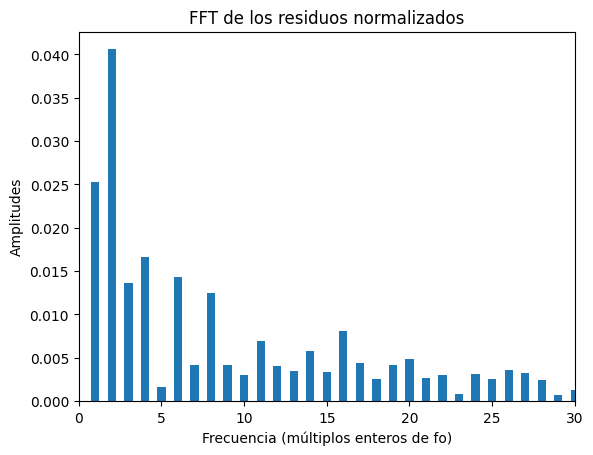

In [19]:
#FFT of residuals:
n_res,t_res,SP_res,f_res = my_fft_week(residuals)
plt.figure(6)
plt.bar(f_res[1:]*Tot,np.abs(SP_res[1:n_res])/n_res,width=0.5)
plt.xlabel('Frecuencia (múltiplos enteros de fo)')
plt.title('FFT de los residuos normalizados')
plt.ylabel('Amplitudes')
plt.xlim(0,30)
#It tends to favor low frequencies (Long cycles)

Text(0, 0.5, 'Valor normalizado')

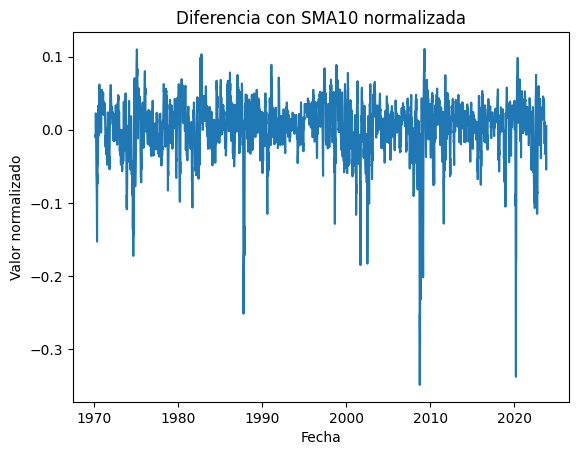

In [9]:
dif10 = (sp_data['Price'][:-9] - sp_MA_10)/(sp_data['Price'][:-9]) #Está normalizado
plt.plot(sp_data['Date'][:-9],dif10)
plt.title('Normalized difference with SMA10')
plt.xlabel('Date')
plt.ylabel('Normalized value')

Text(0, 0.5, 'Valor de la diferencia')

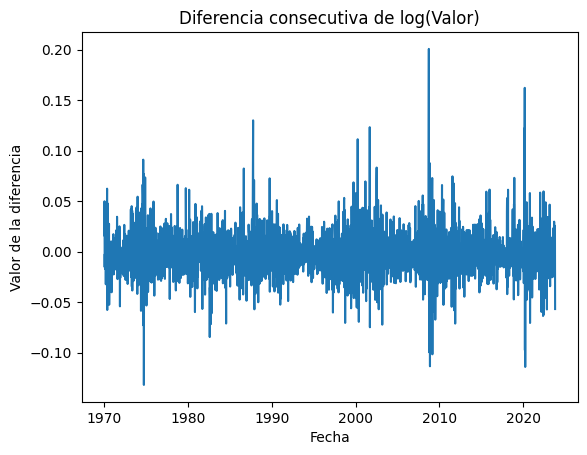

In [10]:
#Consecutive differences method..
sp_data['log Price'] = sp_data['Price'].apply(lambda x: np.log(x))

sp_data['log Difference'] = sp_data['log Price'] - sp_data['log Price'].shift()
plt.plot(sp_data['Date'],sp_data['log Difference'])
plt.title('Consecutive differences of log(Value)')
plt.xlabel('Date')
plt.ylabel('Difference')

/tmp/ipykernel_240/3714431370.py:20: RuntimeWarning: divide by zero encountered in divide
  t_week = (1/f_oneside)/(60*60*24*7)


(0.0, 0.0012)

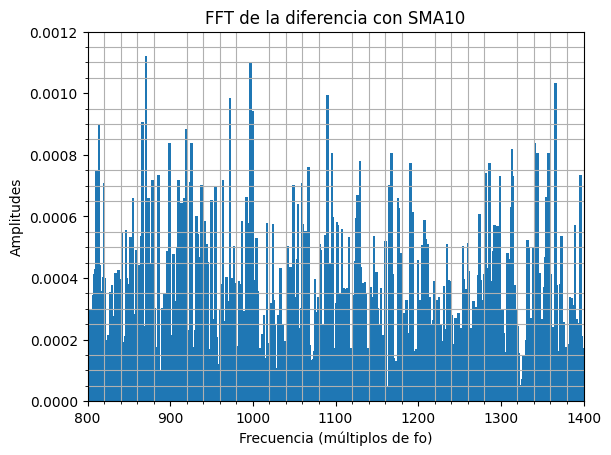

In [18]:
#FFT of price differences with SMA10.
n_dif,t_dif,G_dif,f_dif = my_fft_week(dif10)
plt.figure(10)
plt.bar(f_dif[1:]*Tot,np.abs(np.imag(G_dif[1:n_dif]))/n_dif,width=3)
plt.grid(which='minor')
plt.minorticks_on()
plt.title('FFT of price differences with SMA10')
plt.ylabel('Amplitudes')
plt.xlabel('Frequency (multiples of fo)')


/tmp/ipykernel_240/3714431370.py:20: RuntimeWarning: divide by zero encountered in divide
  t_week = (1/f_oneside)/(60*60*24*7)


(980.0, 1000.0)

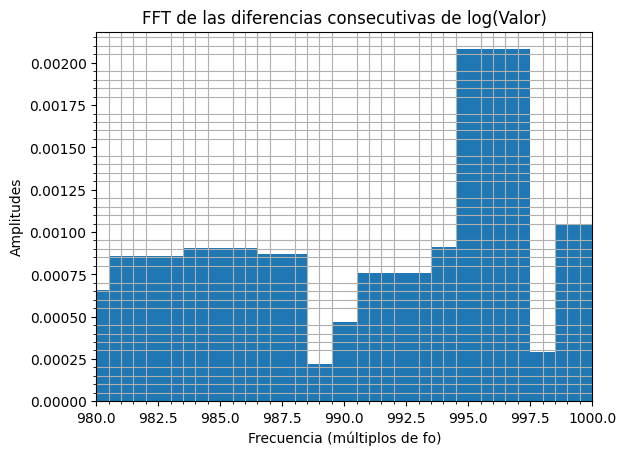

In [20]:
#FFT of consecutive differences
n_diflog,t_diflog,SP_diflog,f_diflog = my_fft_week(sp_data['log Difference'])
plt.figure(10)
plt.bar(f_diflog[1:]*Tot,np.abs(np.imag(SP_diflog[1:n_diflog]))/n_diflog,width=3)
plt.grid(which='minor')
plt.minorticks_on()
plt.title('FFT of consecutive differences for log(Price)')
plt.xlabel('Frequency (multiples of fo)')
plt.ylabel('Amplitudes')
